In [1]:
import paltas
import os
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

root_path = paltas.__path__[0][:-7]

/Users/padmavenkatraman/Documents/StrongLensing/silver/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


# Understanding the Configuration File

__Author:__ Sebastian Wagner-Carena

__Goals:__ 

1. Understand the basic philosophy of the `paltas` configuration file
2. Understand how to specify all of the required parameters in a configuration file
3. Understand how to implement the optional parameters in a configuration file.

### Table of Contents

1. [The Basics](#basics)
2. [Required Parameters](#required_params) 
    1. [Source](#source)
    2. [Main Deflector](#main_deflector)
    3. [Cosmology](#cosmology)
    4. [Detector and PSF](#detector)
    5. [Numerical Parameters](#num_params)
3. [Optional Parameters](#optional_params)
    1. [Subhalos](#subhalos)
    2. [Line-of-Sight Halos](#los)
    3. [Masks and Cuts](#mask_cuts)
    4. [Point Source](#point_source)
    5. [Drizzle](#drizzle)
    6. [Cross-Object Parameters](#cross_object)
4. [Using a Configuration File Without `generate.py`](#no_generate)
    

## The Basics <a class="anchor" id="basics"></a>

**Goal: Understand the basic philosophy of the `paltas` configuration file**

At a high level, `paltas` enhances the lensing calculations being done by `lenstronomy` by making it convenient to generate large, simulated, machine-learning datasets. To do this, `paltas` allows user to translate simple, user-specified distributions for lensing systems into large image datasets without having to interact directly with lenstronomy. For example, say that a researcher wants to generate a dataset of images from a simple two-component lensing distribution: a main deflector whose mass is described by a power-law elliptical mass distribution (PEMD) and a source that can be described by a Sersic profile. To do this they would need to specify a configuration dictionary with the `main_deflector` models (in this case just the PEMD), the source class (in this case a SingleSersicSource) and the parameters for both:
```
config_dict = {
    'main_deflector':{
        'class': PEMD,
        'parameters':{
            'z_lens': 0.5,
            'gamma': 2.0,
            'theta_E': 1.1,
            'e1': 0.05,
            'e2': -0.1,
            'center_x': 0.06,
            'center_y': 0.08,
        }
    },
    'source':{
        'class': SingleSersicSource,
        'parameters':{
            'magnitude':23.0,
            'output_ab_zeropoint':25.127
            'R_sersic':1.0,
            'n_sersic':0.7,
            'e1':0.1,
            'e2':0.3,
            'center_x':0.0,
            'center_y':0.0}
    }
}
```
Throwing this plus a few numerical options<sup>2</sup> into a Config file would be enough to generate a training set with `generate.py`.

```
python generate.py path/to/config/file path/to/output/folder --n 100
```

The training set would be a bit boring since the lensing configuration is static, but that can quickly be fixed by specifying a callable rather than a static number for any parameter. For example the researcher could use the `scipy.stats.norm` object to set:
```
'e1': norm(loc=0.0,scale=0.1).rvs
```
and the first component of the ellipticity would be drawn from a normal distribution. __Any key-value pair in a dict associated to the key `parameters` can contain these callable functions. `generate.py` will populate those values with draws from the callable function__.

All of the work of using lenstronomy to translate from this configuration to a final dataset is contained within `generate.py` and the various modules it calls.

<sup>2</sup> We will describe these in detail when we go over the required parameters.

--------------------

A standard config file is organized as follows:
    
1. A block containing all of the fixed variables that are important for generating images. This includes choices like the image size and any variables that the user wants to define for later reference in the `config_dict`.
2. An object called the `config_dict` that contains all of the information about the lensing system, the source, and the observational effects. The `config_dict` is a dictionary whose keys are each one component of the lensing pipeline, say the main deflector or the PSF. We'll go over all the possible components in the following two sections.

The fastest way to build your own config file is to simply import one of the default configs provided in `paltas/Configs/Examples/` and modify the properties of the lensing configuration. For example, if the researcher above wanted to use a config file `config_example.py` but change the main deflector from a PEMD model to be a PEMD + SHEAR model they could write:

```
from paltas.Configs.Examples.config_example import *

config_dict['main_deflector'] = {
    'class': PEMDShear,
    'parameters':{
        'M200': 1e13,
        'z_lens': 0.5,
        'gamma': truncnorm(-20,np.inf,loc=2.0,scale=0.1).rvs,
        'theta_E': truncnorm(-1.1/0.15,np.inf,loc=1.1,scale=0.15).rvs,
        'e1': norm(loc=0.0,scale=0.1).rvs,
        'e2': norm(loc=0.0,scale=0.1).rvs,
        'center_x': norm(loc=0.0,scale=0.16).rvs,
        'center_y': norm(loc=0.0,scale=0.16).rvs,
        'gamma1': norm(loc=0.0,scale=0.05).rvs,
        'gamma2': norm(loc=0.0,scale=0.05).rvs,
        'ra_0':0.0, 'dec_0':0.0
    }
}
```

----------

## Required Parameters <a class="anchor" id="required_params"></a>

**Goal: Understand how to specify all of the required parameters in a configuration file**

In this section we'll describe each of the parameters that must be provided to create a valid `paltas` config. We will assume throughout that the you are using classes that are already implemented in `paltas`, but the `Understanding_Pipeline.ipynb` notebook explains how to implement your own classes.

### Source <a class="anchor" id="source"></a>

The `config_module` in `paltas` must have `source` as one of its entries. The `source` entry must include a `dict` with keys `class` and `parameters`.

`class` specifies the class that will be used to draw the source. This should not be an instance of the class, just the callable class object. The sources implemented in `paltas` can be found in `paltas/Sources`.

`parameters` should specify a dictionary that includes all of the parameters the class will need (see the required parameters described in the docstring of each source class). Each parameter must be associated either to a fixed value or to a callable function that will return a value when called _without any inputs_.

Putting that together we get:

```
from paltas.Sources.sersic import SingleSersicSource
from scipy.stats import norm 

config_dict = {
    'source':{
        'class': SingleSersicSource,
        'parameters':{
            'magnitude':23.0,
            'output_ab_zeropoint':25.127
            'R_sersic':1.0,
            'n_sersic':0.7,
            'e1':norm(loc=0.0,scale=0.16).rvs,
            'e2':0.3,
            'center_x':0.0,
            'center_y':0.0}
    }
}
```

### Main Deflector <a class="anchor" id="main_deflector"></a>

The `config_module` in paltas must have `main_deflector` as one of its entries. The `main_deflector` entry must include a `dict` with keys `class` and `parameters`. As with the source, the `class` is a class instance used to draw the main deflector and the `parameters` specify the required parameters for the main deflector.

The `main_deflector` classes implemented in paltas can be found in `paltas/MainDeflector`. Adding to the previous section we have:

```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from scipy.stats import norm 

config_dict = {
    'source':{
        'class': SingleSersicSource,
        'parameters':{
            'magnitude':23.0,
            'output_ab_zeropoint':25.127
            'R_sersic':1.0,
            'n_sersic':0.7,
            'e1':norm(loc=0.0,scale=0.16).rvs,
            'e2':0.3,
            'center_x':0.0,
            'center_y':0.0}
    },
    'main_deflector':{
        'class': PEMDShear,
        'parameters':{
            'M200': 1e13,
            'z_lens': 0.5,
            'gamma': truncnorm(-20,np.inf,loc=2.0,scale=0.1).rvs,
            'theta_E': truncnorm(-1.1/0.15,np.inf,loc=1.1,scale=0.15).rvs,
            'e1': norm(loc=0.0,scale=0.1).rvs,
            'e2': norm(loc=0.0,scale=0.1).rvs,
            'center_x': norm(loc=0.0,scale=0.16).rvs,
            'center_y': norm(loc=0.0,scale=0.16).rvs,
            'gamma1': norm(loc=0.0,scale=0.05).rvs,
            'gamma2': norm(loc=0.0,scale=0.05).rvs,
            'ra_0':0.0, 'dec_0':0.0
        }
    }
}
```

### Cosmology <a class="anchor" id="cosmology"></a>

The `config_module` in paltas must have `cosmology` as one of its entries. The `cosmology` must include a dict with the key `parameters`. The value of `parameters` can be one of four things:

1. A string specifying the name of the cosmology in colossus. See https://bdiemer.bitbucket.io/colossus/cosmology_cosmology.html#standard-cosmologies for a list of options.
2. A dictionary with the value `cosmology_name` and the name of the cosmology in colossues
3. A dictionary with the values `H0,Om0,Ob0,sigma8,ns` corresponding to the hubble constant, Omega matter, Omega baryon, sigma 8, and n_s.
4. An instance of the colossus.cosmology.cosmology.Cosmology object. See https://bdiemer.bitbucket.io/colossus/cosmology_cosmology.html# for details.

Note that no class is required for the cosmology object. You can also specify a callable for cosmology as with any parameter in the `config_module`. This allows you to sample from multiple cosmologies when drawing lenses. Adding this to the config we've been building we get:

```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from scipy.stats import norm 

config_dict = {
    'source':{
        'class': SingleSersicSource,
        'parameters':{
            'magnitude':23.0,
            'output_ab_zeropoint':25.127
            'R_sersic':1.0,
            'n_sersic':0.7,
            'e1':norm(loc=0.0,scale=0.16).rvs,
            'e2':0.3,
            'center_x':0.0,
            'center_y':0.0}
    },
    'main_deflector':{
        'class': PEMDShear,
        'parameters':{
            'M200': 1e13,
            'z_lens': 0.5,
            'gamma': truncnorm(-20,np.inf,loc=2.0,scale=0.1).rvs,
            'theta_E': truncnorm(-1.1/0.15,np.inf,loc=1.1,scale=0.15).rvs,
            'e1': norm(loc=0.0,scale=0.1).rvs,
            'e2': norm(loc=0.0,scale=0.1).rvs,
            'center_x': norm(loc=0.0,scale=0.16).rvs,
            'center_y': norm(loc=0.0,scale=0.16).rvs,
            'gamma1': norm(loc=0.0,scale=0.05).rvs,
            'gamma2': norm(loc=0.0,scale=0.05).rvs,
            'ra_0':0.0, 'dec_0':0.0
        }
    },
    'cosmology':{
        'parameters':{
            'cosmology_name': 'planck18'
        }
    }
}
```

### Detector and PSF <a class="anchor" id="detector"></a>

In order to finish rendering the observation, `paltas` needs the user to specify the PSF parameters and the detector parameters.

For the PSF, the `config_dict` needs to have the key `psf`, which like cosmology needs to be a dict with the key `parameters`. `parameters` should point to a dictionary with one entry specifying `psf_type` and the remaining entries specifying the lenstronomy kwargs required for that kind of PSF. For example, for `psf_type = PIXEL` lenstronomy requires a `kernel_point_source` array that gives the PSF. If this PSF is sampled at a higher resolution than the CCD then the user also needs to specify `point_source_supersampling_factor` with the supersampling multiplier. See https://lenstronomy.readthedocs.io/en/latest/_modules/lenstronomy/Data/psf.html for more details on the lenstronomy PSFs.

For the detector, the `config_dict` needs to have the key `detector`, which again points to a dict with the key `parameters`, which itself points to a dict. The keys of this dict include:

`pixel_scale` - the pixel scale of the image in units of arcseconds
`ccd_gain` - the CCD gain of the detector
`read_noise` - the RMS read noise of the detector in units of electrons
`magnitude_zero_point` - the AB magnitude zero point of the detector
`exposure_time` - the exposure time for the observation in units of seconds
`sky_brightness` - the brightness of the sky in units of magnitude per squared arcsecond. 
`num_exposures` - the number of exposures per observation (this will be ignored if drizzling is used, see the drizzle section)
`background_noise` - RMS background noise in units of electrons. If set will ignore `read_noise` and `sky_brightness`.

These parameters are then fed into the Lenstronomy SingleBand class, which can be found here: https://lenstronomy.readthedocs.io/en/latest/_modules/lenstronomy/SimulationAPI/observation_api.html#SingleBand. 

Adding those two components to our config dict we get:

```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from scipy.stats import norm 
from astropy.io import fits

############### NEW #########################
# Read the PSF from a fits file.
hdul = fits.open('path/to/psf.fits'))[0].data
#############################################

config_dict = {
    'source':{
        'class': SingleSersicSource,
        'parameters':{
            'magnitude':23.0,
            'output_ab_zeropoint':25.127
            'R_sersic':1.0,
            'n_sersic':0.7,
            'e1':norm(loc=0.0,scale=0.16).rvs,
            'e2':0.3,
            'center_x':0.0,
            'center_y':0.0}
    },
    'main_deflector':{
        'class': PEMDShear,
        'parameters':{
            'M200': 1e13,
            'z_lens': 0.5,
            'gamma': truncnorm(-20,np.inf,loc=2.0,scale=0.1).rvs,
            'theta_E': truncnorm(-1.1/0.15,np.inf,loc=1.1,scale=0.15).rvs,
            'e1': norm(loc=0.0,scale=0.1).rvs,
            'e2': norm(loc=0.0,scale=0.1).rvs,
            'center_x': norm(loc=0.0,scale=0.16).rvs,
            'center_y': norm(loc=0.0,scale=0.16).rvs,
            'gamma1': norm(loc=0.0,scale=0.05).rvs,
            'gamma2': norm(loc=0.0,scale=0.05).rvs,
            'ra_0':0.0, 'dec_0':0.0
        }
    },
    'cosmology':{
        'parameters':{
            'cosmology_name': 'planck18'
        }
    },
############### NEW #########################
    'psf':{
        'parameters':{
            'psf_type':'PIXEL',
            'kernel_point_source': psf_pix_map,
            'point_source_supersampling_factor':2
        }
    },
    'detector':{
        'parameters':{
            'pixel_scale':0.040,'ccd_gain':1.58,'read_noise':3.0,
            'magnitude_zero_point':output_ab_zeropoint,
            'exposure_time':1380,'sky_brightness':21.83,
            'num_exposures':1,'background_noise':None
        }
    }
#############################################
}
```

### Numerical Parameters <a class="anchor" id="num_params"></a>

Finally, there are a few numerical parameters that need to be specified for best results. The most important is the number of pixels which is specified via `numpix`. This is not a property of `config_dict` but rather the entire configuration file. The second are the `kwargs_numerics` that will be passed to lenstronomy. For a full discussion of those parameters see https://lenstronomy.readthedocs.io/en/latest/_modules/lenstronomy/ImSim/Numerics/numerics.html, but practically speaking the most important parameter to specify is the `supersampling_factor`. This determines if the raytracing will be done at a higher resolution than the CCD to improve fidelity.

Adding these two remaining pieces we get:

```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from scipy.stats import norm 
from astropy.io import fits

# Read the PSF from a fits file.
hdul = fits.open('path/to/psf.fits'))[0].data

############### NEW #########################
kwargs_numerics = {'supersampling_factor':1}
numpix = 128
#############################################

config_dict = {
    'source':{
        'class': SingleSersicSource,
        'parameters':{
            'magnitude':23.0,
            'output_ab_zeropoint':25.127
            'R_sersic':1.0,
            'n_sersic':0.7,
            'e1':norm(loc=0.0,scale=0.16).rvs,
            'e2':0.3,
            'center_x':0.0,
            'center_y':0.0}
    },
    'main_deflector':{
        'class': PEMDShear,
        'parameters':{
            'M200': 1e13,
            'z_lens': 0.5,
            'gamma': truncnorm(-20,np.inf,loc=2.0,scale=0.1).rvs,
            'theta_E': truncnorm(-1.1/0.15,np.inf,loc=1.1,scale=0.15).rvs,
            'e1': norm(loc=0.0,scale=0.1).rvs,
            'e2': norm(loc=0.0,scale=0.1).rvs,
            'center_x': norm(loc=0.0,scale=0.16).rvs,
            'center_y': norm(loc=0.0,scale=0.16).rvs,
            'gamma1': norm(loc=0.0,scale=0.05).rvs,
            'gamma2': norm(loc=0.0,scale=0.05).rvs,
            'ra_0':0.0, 'dec_0':0.0
        }
    },
    'cosmology':{
        'parameters':{
            'cosmology_name': 'planck18'
        }
    },
    'psf':{
        'parameters':{
            'psf_type':'PIXEL',
            'kernel_point_source': psf_pix_map,
            'point_source_supersampling_factor':2
        }
    },
    'detector':{
        'parameters':{
            'pixel_scale':0.040,'ccd_gain':1.58,'read_noise':3.0,
            'magnitude_zero_point':output_ab_zeropoint,
            'exposure_time':1380,'sky_brightness':21.83,
            'num_exposures':1,'background_noise':None
        }
    }
}
```

## Optional Parameters <a class="anchor" id="optional_params"></a>

**Goal: Understand how to implement the optional parameters in a configuration file.**

There are a number of optional parameters that do not need to be specified to use a config file. However, many of these parameters add the complexity to the lensing system demanded by studies of dark matter halos.

### Subhalos <a class="anchor" id="subhalos"></a>

The `config_module` in `paltas` can have `subhalo` as one of its entries. The `subhalo` entry must include a `dict` with keys `class` and `parameters`. As with the source and main deflector, the `class` is a class instance used to draw the subhalos and the `parameters` specify the required parameters for the subhalos.

The subhalo classes implemented in paltas can be found in `paltas/Substructure`. Adding to the previous section we have:

```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from paltas.Substructure.subhalos_dg19 import SubhalosDG19
from scipy.stats import norm 
from astropy.io import fits

...

config_dict = {
############### NEW #########################
    'subhalo':{
        'class': SubhalosDG19,
        'parameters':{
            'sigma_sub':norm(loc=2e-3,scale=1.1e-3).rvs,
            'shmf_plaw_index':uniform(loc=-1.92,scale=0.1).rvs,
            'm_pivot': 1e10,'m_min': 1e7,'m_max': 1e10,
            'c_0':uniform(loc=16,scale=2).rvs,
            'conc_zeta':uniform(loc=-0.3,scale=0.1).rvs,
            'conc_beta':uniform(loc=0.55,scale=0.3).rvs,
            'conc_m_ref': 1e8,
            'dex_scatter': uniform(loc=0.1,scale=0.06).rvs,
            'k1':0.0, 'k2':0.0
        }
    },
#############################################
...
```

### Line-of-Sight Halos <a class="anchor" id="los"></a>

The `config_module` in `paltas` can have `los` as one of its entries. The `los` entry must include a `dict` with keys `class` and `parameters`. As with the subhalos, the `class` is a class instance used to draw the line-of-sight halos and the `parameters` specify the required parameters for the los halos.

The los classes implemented in paltas can be found in `paltas/Substructure`. Adding to the previous section we have:


```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from paltas.Substructure.subhalos_dg19 import SubhalosDG19
from paltas.Substructure.los_dg19 import LOSDG19
from scipy.stats import norm 
from astropy.io import fits

...

config_dict = {
############### NEW #########################
    'los':{
        'class': LOSDG19,
        'parameters':{
            'delta_los':norm(loc=1,scale=0.6).rvs,
            'm_min':1e7,'m_max':1e10,'z_min':0.01,
            'dz':0.01,'cone_angle':8.0,'r_min':0.5,'r_max':10.0,
            'c_0':uniform(loc=16,scale=2).rvs,
            'conc_zeta':uniform(loc=-0.3,scale=0.1).rvs,
            'conc_beta':uniform(loc=0.55,scale=0.3).rvs,
            'conc_m_ref': 1e8,
            'dex_scatter': uniform(loc=0.1,scale=0.06).rvs,
            'alpha_dz_factor':5.0
        }
    },
#############################################
...
```

### Masks and Cuts <a class="anchor" id="mask_cuts"></a>

The config allows the user to specify a central mask (to mock the effects of lens light removal) via the parameter `mask_radius`. The mask is centered, circular, and has a radius defined by `mask_radius` in units of arcseconds.

The config file also allows the user to specify a minimum magnification of the source flux required for a lens to be accepted. This is useful for configurations that occasionally result in no lensing. It is specified by giving a float value to the parameter `mag_cut`. Adding these components:

```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from paltas.Substructure.subhalos_dg19 import SubhalosDG19
from paltas.Substructure.los_dg19 import LOSDG19
from scipy.stats import norm 
from astropy.io import fits

...

############### NEW #########################
# Define some general image kwargs for the dataset
mask_radius = 0.5
mag_cut = 2.0
#############################################
...
```

### Point Source <a class="anchor" id="point_source"></a>

The `config_module` in `paltas` can have `point_source` as one of its entries. Because they do not have an extended flux, point sources are treated differently in lenstronomy than a normal source. The `point_source` entry must include a `dict` with keys `class` and `parameters`. The `class` is a class instance used to draw the point source and the `parameters` specify the required parameters for the point source.

The point source classes implemented in paltas can be found in `paltas/PointSource`. Adding to the previous section we have:


```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from paltas.Substructure.subhalos_dg19 import SubhalosDG19
from paltas.Substructure.los_dg19 import LOSDG19
from paltas.PointSource.single_point_source import SinglePointSource
from scipy.stats import norm, uniform 
from astropy.io import fits

...

config_dict = {
############### NEW #########################
    point_source':{
        'class': SinglePointSource,
        'parameters':{
            'x_point_source':0.0,
            'y_point_source':0.0,
            'magnitude':uniform(loc=20,scale=2.5).rvs,
            'output_ab_zeropoint':25.127
        }
    },
#############################################
...
```

### Drizzle <a class="anchor" id="drizzle"></a>

`paltas` offers the ability to recreate the Hubble Space Telescope drizzle pipeline in the image simulations. To take advantage of this feature the user needs to add the key `drizzle` to the configuration dictionary. This needs to point to a dictionary with the key `parameters` that itself points to a dictionary with the keys:

`supersample_pixel_scale` - the pixel scale at which to simulate the ray tracing in units of arcseconds. This should be smaller or equal to both the pixel scale of the detector and the pixel scale at which drizzle will be outputted.
`output_pixel_scale` - the pixel scale to target with the drizzle output
`wcs_distortion` - An instance of the astropy.wcs.wcs.WCS class that includes the desired gemoetric distortions from the detector as SIP coefficients. This can be set to None.
`offset_pattern` - The dithering strategy to simulate. This should be a list of tuples. Each tuple specifies an offset in units of pixels, and the length of the list determines the number of simulated exposures. These dithered exposures will then be used as the input to the drizzle pipeline.
`psf_supersample_factor` - The supersampled resolution at which to apply the psf model. Essentially, is your psf supersampled, and at what factor.

Adding this to the `config_dict` we get:


```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from paltas.Substructure.subhalos_dg19 import SubhalosDG19
from paltas.Substructure.los_dg19 import LOSDG19
from paltas.PointSource.single_point_source import SinglePointSource
from scipy.stats import norm, uniform 
from astropy.io import fits

...

config_dict = {
############### NEW #########################
    'drizzle':{
        'parameters':{
            'supersample_pixel_scale':0.020,'output_pixel_scale':0.030,
            'wcs_distortion':None,
            'offset_pattern':[(0,0),(0.5,0),(0.0,0.5),(-0.5,-0.5)],
            'psf_supersample_factor':2
        }
    },
#############################################
...
```

### Cross-Object Parameters <a class="anchor" id="cross_object"></a>

All of the key-value pairs in a `parameters` dictionaries can be specified by callables that are called when sampling lens parameters. This allows the user to vary parameters within the training set, but does not allow the user to build correlations between parameters. To account for this, the `config_dict` allows the user to provide the key `cross_object` that points to a `parameters` dictionary of multi-parameter distribution. For example, if I wanted to draw the subhalo parameter `c_0` and the los parameter `c_0` from a multidimensional distribution all I would need to specify is:

```
'cross_object':{
    'parameters':{
        'subhalo:c_0,los:c_0':multi_dim_distribution
    }
}
```
The format is `object` : `parameter` , `object` : `parameter`, ... 

`multi_dim_distribution` then has to output a vector with the number of parameters specified in the list, in this case 2.

`cross_object` gets the final say on parameter values. So if you've specified a different callable distribution for `c_0` in the `subhalo` and `los` dictionary, it will be overwritten by the draw from `multi_dim_distribution`. Some useful distributions can be found in `paltas/Sampling/distributions.py`.

Adding this to our example we get:

```
from paltas.MainDeflector.simple_deflectors import PEMDShear
from paltas.Sources.sersic import SingleSersicSource
from paltas.Substructure.subhalos_dg19 import SubhalosDG19
from paltas.Substructure.los_dg19 import LOSDG19
from paltas.PointSource.single_point_source import SinglePointSource
from paltas.Sampling import distributions
from scipy.stats import norm, uniform 
from astropy.io import fits

...

config_dict = {
############### NEW #########################
    'cross_object':{
        'parameters':{
            'subhalo:c_0,los:c_0':distributions.Duplicate(
                dist=uniform(loc=16,scale=2).rvs),
            'subhalo:conc_zeta,los:conc_zeta':distributions.Duplicate(
                dist=uniform(loc=-0.3,scale=0.1).rvs),
            'subhalo:conc_beta,los:conc_beta':distributions.Duplicate(
                dist=uniform(loc=0.55,scale=0.3).rvs),
            'subhalo:dex_scatter,los:dex_scatter':distributions.Duplicate(
                dist=uniform(loc=0.1,scale=0.06).rvs)
        }
    },
#############################################
...
```

## Using a Configuration File Without `generate.py` <a class="anchor" id="no_generate"></a>

Some users may be interested in interacting with the configuration file outputs more directly, either to extract the lenstronomy parameters or to draw individual images programatically. This is possible through the use of the `ConfigHandler` class. The class takes as input the path to a configuration file and can return a draw of the lenstronomy parameters or an image with the corresponding metadata. Let's work through an example in the code below:

In [5]:
from paltas.Configs.config_handler import ConfigHandler

# We'll pass one of our example Configs in
config_handler = ConfigHandler(os.path.join(root_path,'lsst_config.py'))

# First let's get the lenstronomy model lists, kwargs lists, and redshift lists.
kwargs_model, kwargs_params = config_handler.get_lenstronomy_models_kwargs()

# We can see what keys are returned, and inspect the lens models in particular
print('Available Keys:')
print(kwargs_model.keys())
print(kwargs_params.keys())
print('')

print('lens_model_list')
print(kwargs_model['lens_model_list'])
print('kwargs_lens')
print(kwargs_params['kwargs_lens'])

Available Keys:
dict_keys(['lens_model_list', 'lens_redshift_list', 'lens_light_model_list', 'point_source_model_list', 'source_light_model_list', 'source_redshift_list', 'multi_plane', 'z_source', 'z_source_convention'])
dict_keys(['kwargs_lens', 'kwargs_lens_light', 'kwargs_ps', 'kwargs_source'])

lens_model_list
['EPL_NUMBA', 'SHEAR']
kwargs_lens
[{'theta_E': 0.8485381313057039, 'gamma': 1.7391982348206902, 'e1': -0.2705014668148231, 'e2': 0.12364388599122687, 'center_x': -0.021378364501107288, 'center_y': 0.030819818331205902}, {'gamma1': 0.2492443211031915, 'gamma2': 0.05601665659186192, 'ra_0': 0.0, 'dec_0': 0.0}]


/Users/padmavenkatraman/Documents/StrongLensing/paltas/paltas/Sampling/sampler.py:110: UserWarning: Parameter center_x in cross dict specified elsewhere! Will be overwritten. This warning only flags once, but other parameters may also be overwritten.
  warnings.warn('Parameter %s in cross dict specified '%(param)


/Users/padmavenkatraman/Documents/StrongLensing/paltas/paltas/Configs/config_handler.py:354: RuntimeWarning: Parameter (point_source_parameters, mag_pert) in config_dict, and possibly others, will not be written to metadata.csv
  warnings.warn(


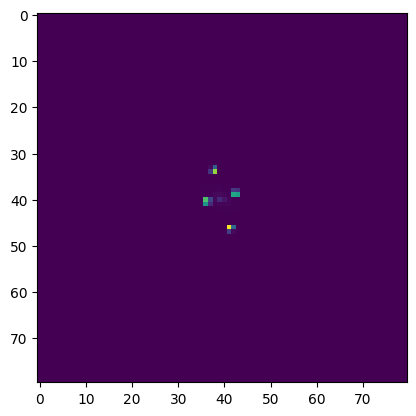

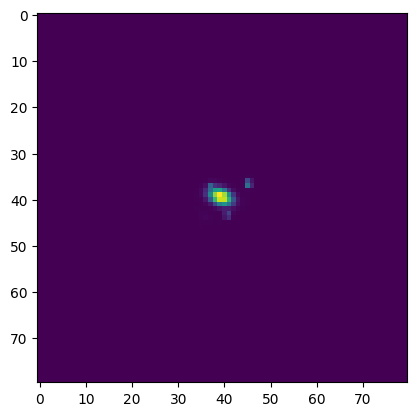

In [6]:
# Similarly, we can use the handler to generate an image.
image,metadata = config_handler.draw_image()
image_norm = simple_norm(image,stretch='asinh')
plt.imshow(image,norm=image_norm)
plt.show()

image,metadata = config_handler.draw_image()
image_norm = simple_norm(image,stretch='asinh')
plt.imshow(image,norm=image_norm)
plt.show()

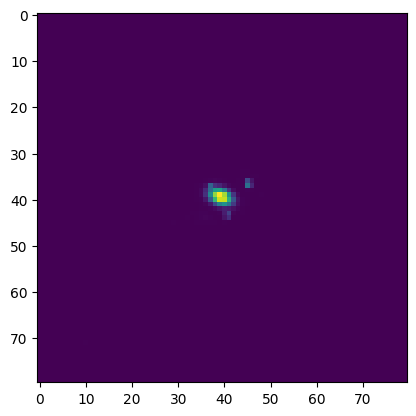

In [7]:
# If we want to draw another image without resampling from the parameter space, we can also specify that
image,metadata = config_handler.draw_image(new_sample=False)
image_norm = simple_norm(image,stretch='asinh')
plt.imshow(image,norm=image_norm)
plt.show()